## Data 분포 및 이미지 확인

In [1]:
import pandas as pd 
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [2]:
# csv 파일 읽어서 id, 라벨값 확인
path_data="./histopathologic_cancer_detection/train_labels.csv"
labels_df=pd.read_csv(path_data)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


0    130908
1     89117
Name: label, dtype: int64


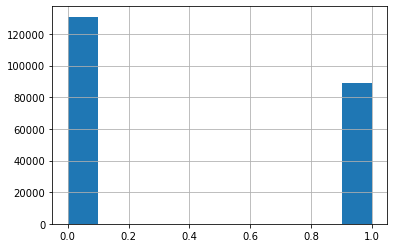

In [3]:
# 각 라벨값 수 count
print(labels_df['label'].value_counts())

# 양성(0)/음성(1) - histogram 확인(분포)
labels_df['label'].hist();

In [4]:
# train data 경로 설정
path_train="./histopathologic_cancer_detection/train/"

# 이미지를 흑백으로 설정
color=False
# color= True


# 양성(1)인 라벨의 id값을 malignantIds에 지정(list형태로 저장)
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# print(malignantIds)

# 불러올 총 이미지의 크기를 10x10으로 지정
plt.rcParams['figure.figsize'] = (20.0, 20.0)
# 공백없애기 위해 설정
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

<Figure size 1440x1440 with 0 Axes>

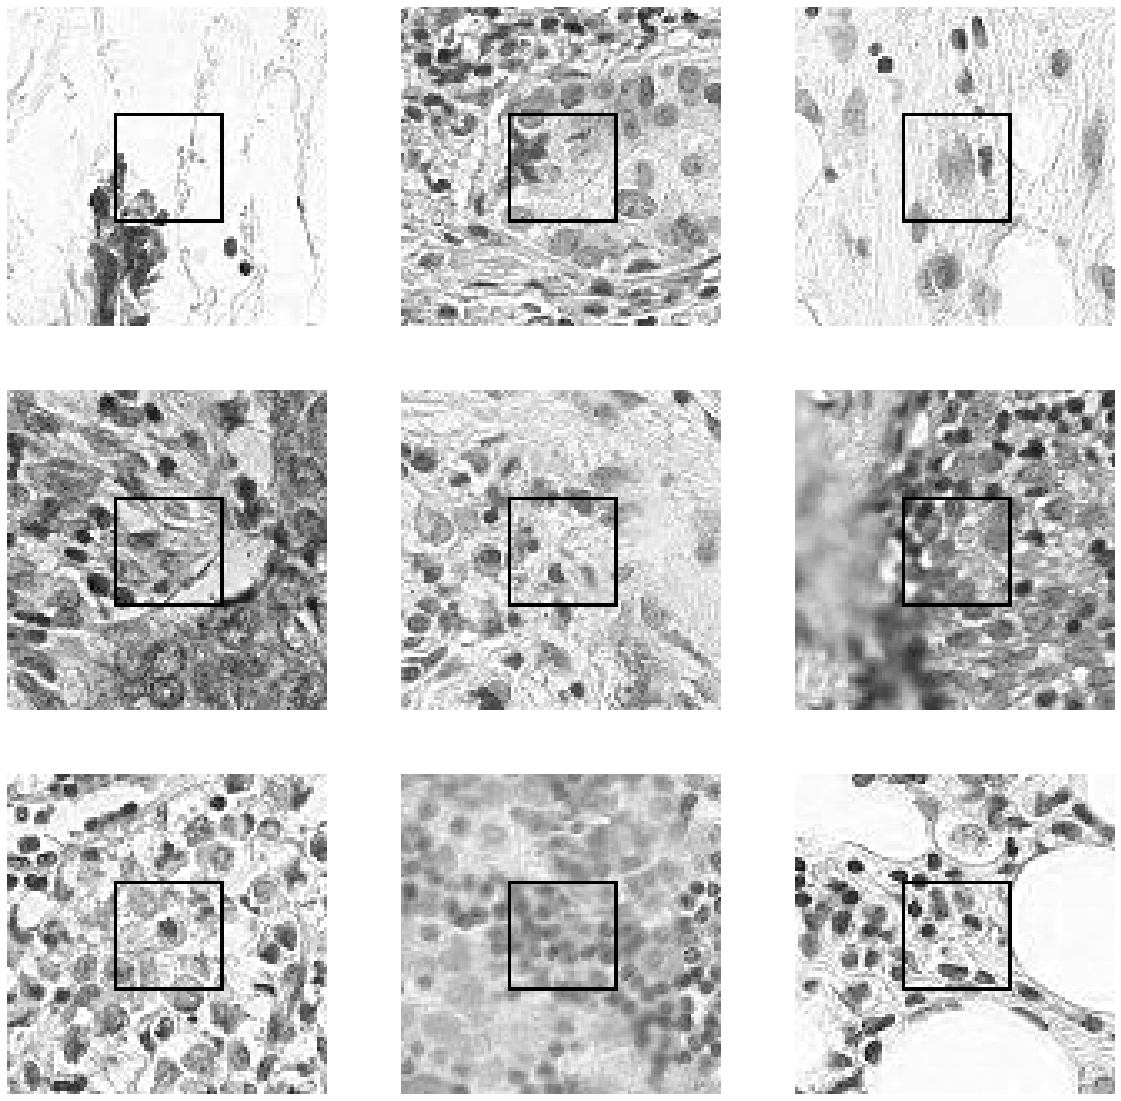

In [5]:
# malignantIds: 양성(1)인 리스트에서 3x3개를 순서대로 뽑아옴 -> (index, id)형태로
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    # train경로에서 id를 조합해서 이미지 경로 설정
    full_filenames = os.path.join(path_train , id_ +'.tif')
 
    # 이미지 경로로 이미지 open
    img = Image.open(full_filenames)

    # 이미지에 32x32크기의 박스를 초록색라인으로 그림
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)), outline="green")

	# 3x3 사이즈로 subplot생성, 1부터 시작해야하므로 0번째부터 시작하는 index에 +1
    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    
    # 흑백으로 불러올경우 채널을 하나만 불러와서 cmap을 gray로 설정
    else:
        plt.imshow(np.array(img)[:,:,0], cmap="gray")
    plt.axis('off')

In [6]:
# 이미지를 np.array()에 넣어서 크기 확인
print("image shape:", np.array(img).shape)
# 픽셀의 최대, 최소 값 확인
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


## Dataset 확인

In [8]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os
from glob import glob

In [9]:
# 랜덤 seed설정해서 랜덤값 고정
torch.manual_seed(0)

In [10]:
# 경로설정 확인
data_dir = "./histopathologic_cancer_detection"
data_type = "train"
path_data = os.path.join(data_dir,data_type)

print(len(glob(os.path.join(data_dir,data_type,'*.tif'))))
print(path_data)
print(type(path_data))
print(len(os.listdir(path_data)))

220025
./histopathologic_cancer_detection\train
<class 'str'>
220025


In [53]:
# customeCancerDataSet(Dataset) 클래스 정의
class customeCancerDataSet(Dataset):

    # def initData(self, data_dir, transform, data_type="train"):
    def __init__(self, data_dir, transform, data_type="train"):
        # data_dir : train / test 데이터 폴더가 들어있는 상위 directory
        # data_type : train으로 고정해서 train 폴더경로를 조합
        path_data = os.path.join(data_dir, data_type)

        # train 폴더 경로에 있는 모든 파일을 list형태로 불러온다
        filenames = os.listdir(path_data)

        # 위에서 불러온 train 폴더내의 filenames 리스트에서 하나씩 불러와서 상위 디렉토리 주소와 조합
        self.full_filenames = [os.path.join(path_data, f) for f in filenames]

        # 데이터 상위 디렉토리와 csv경로를 조합
        pathWithLabels = os.path.join(data_dir, "train_labels.csv")
        # csv파일을 DataFrame으로 읽어옴
        labels_df = pd.read_csv(pathWithLabels)

        # id 컬럼을 인덱스로 설정
        labels_df.set_index("id", inplace=True)

        # .tif를 제외한 파일이름의 위치를 지정해서 labels_df에서 라벨값을 불러옴
        self.labels = [labels_df.loc[filename[:-4]].values[0]
                       for filename in filenames]

        # transform 정의
        self.transform = transform
        

#     def lenOfData(self):
    def __len__(self):   
      # 파일의 개수확인
        return len(self.full_filenames)

    
#     def getItem(self, idx):
    def __getitem__(self, idx):
        # 인덱스를 지정해서 이미지오픈
        image = Image.open(self.full_filenames[idx])
        # 이미지 변환
        image = self.transform(image)
        # 불러온 이미지, 이미지의 라벨값 리턴
        return image, self.labels[idx]

In [60]:
# Transform설정 : type을 텐서타입으로 변경(0~1)
data_transformer = transforms.Compose([transforms.ToTensor()])

# 기본경로 설정
data_dir = "./histopathologic_cancer_detection"

# customeCancerDataSet()에 파라미터 형성
custom_dataset = customeCancerDataSet(data_dir, data_transformer, "train")

In [54]:
len(custom_dataset)

220025

In [61]:
img,label = custom_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [62]:
custom_dataset[9]

(tensor([[[0.7216, 0.6157, 0.5294,  ..., 0.8824, 0.8863, 0.8863],
          [0.7490, 0.5961, 0.5961,  ..., 0.8863, 0.8863, 0.8902],
          [0.6000, 0.6980, 0.5843,  ..., 0.8902, 0.8784, 0.8784],
          ...,
          [0.6627, 0.7686, 0.8627,  ..., 0.5725, 0.8588, 0.6157],
          [0.7686, 0.9647, 0.7333,  ..., 0.5804, 0.8588, 0.6745],
          [0.5804, 0.9647, 0.9373,  ..., 1.0000, 0.8000, 0.6941]],
 
         [[0.3255, 0.2392, 0.1843,  ..., 0.8863, 0.8902, 0.8902],
          [0.4510, 0.2980, 0.2980,  ..., 0.8824, 0.8824, 0.8863],
          [0.4235, 0.5020, 0.3490,  ..., 0.8706, 0.8706, 0.8706],
          ...,
          [0.2941, 0.4392, 0.5804,  ..., 0.3255, 0.5804, 0.3412],
          [0.3961, 0.6353, 0.4510,  ..., 0.3216, 0.5451, 0.3451],
          [0.2039, 0.6314, 0.6471,  ..., 0.7412, 0.4667, 0.3333]],
 
         [[0.6235, 0.5294, 0.4824,  ..., 0.8941, 0.8980, 0.8980],
          [0.7333, 0.5804, 0.5882,  ..., 0.9020, 0.9020, 0.9059],
          [0.6863, 0.7725, 0.6314,  ...,

In [46]:
# Transform 설정
data_transformer = transforms.Compose([transforms.ToTensor()])

data_dir = "./histopathologic_cancer_detection/"

# 함수형태로 불러옴!!
custom_dataset = customeCancerDataSet(data_dir, data_transformer, "train").lenOfData()
print(custom_dataset)


# getItem()으로 불러와야하는 형식이 아닌가??
getitem=customeCancerDataSet(data_dir, data_transformer, "train").getItem(9)
# img,label=custom_dataset[9]
img,label=getitem

print(img.shape,torch.min(img),torch.max(img))



220025
torch.Size([3, 96, 96]) tensor(0.) tensor(1.)
